### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

shap.initjs()

### Helper Functions

In [2]:
def load_data(dataset, classifier):
    path = Path(f'E:/Eighth Semester/EEE Capstone/8th Semester/{dataset}/{classifier}')
    os.chdir(path)
    df = pd.read_csv('df_encoded.csv')

    with open(f'{classifier}_selected_features.pkl', 'rb') as f:
        corr_features, chi_sq_features, seq_fea_sel_features, rfe_cv_features = pickle.load(f)

    return df, seq_fea_sel_features


def preprocess_data(df, features):
    Y = df['churn']
    X = df[features]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


def create_model(classifier):
    if classifier == 'RF':
        model = RandomForestClassifier(n_jobs=-1, random_state=42)
    elif classifier == 'BRF':
        model = BalancedRandomForestClassifier(n_jobs=-1, random_state=42)
    else:
        model = XGBClassifier(n_jobs=-1, random_state=42)
    return model


def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model


def calculate_shap_values(model, X_test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    return shap_values, explainer


def generate_summary_plot(shap_values, classifier, X_test):
    
    # Check if shap_values is a list (for BRF)
    if isinstance(shap_values, list):
        # Plot for class 1 (change index as needed)
        shap_values_to_plot = shap_values[1]
    else:
        # For XGBoost, shap_values is already an array
        shap_values_to_plot = shap_values

    # Create the summary plot
    shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar", show=False)
    fig = plt.gcf()
    fig.set_figwidth(14)
    fig.set_figheight(8)
    ax = plt.gca()
    ax.set_title('Feature Importance (Summary)')
    # Save the plot as a png image
    plt.savefig(f'{classifier}_shap_summary_plot.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'{classifier}_shap_summary_plot.pdf', bbox_inches='tight')
    plt.savefig(f'{classifier}_shap_summary_plot.svg', bbox_inches='tight')
    plt.show()

def generate_beeswarm_plot(shap_values, classifier, X_test):
    # Check if shap_values is a list (for BRF)
    if isinstance(shap_values, list):
        # Plot for class 1 (change index as needed)
        shap_values_to_plot = shap_values[1]
    else:
        # For XGBoost, shap_values is already an array
        shap_values_to_plot = shap_values

    # Create the summary plot
    shap.summary_plot(shap_values_to_plot, X_test, show=False)
    fig = plt.gcf()
    fig.set_figwidth(14)
    fig.set_figheight(8)
    ax = plt.gca()
    ax.set_title('Feature Importance (Beeswarm)')
    # Save the plot as a png image
    plt.savefig(f'{classifier}_shap_beeswarm_plot.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'{classifier}_shap_beeswarm_plot.pdf', bbox_inches='tight')
    plt.savefig(f'{classifier}_shap_beeswarm_plot.svg', bbox_inches='tight')
    plt.show()
   

def generate_force_plot(explainer, shap_values, X_test, classifier, index):
    # Create the force plot
    shap_plot = shap.force_plot(explainer.expected_value, shap_values[index,:], X_test.iloc[index,:], link='logit', matplotlib=True, show=False)

    fig = plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(8)
    ax = plt.gca()
    ax.set_title('Force Plot')
    # Save the plot as a png image
    plt.savefig(f'{classifier}_shap_force_plot_{index}.png', bbox_inches='tight', dpi=300)
    plt.show() 

def generate_dependence_plot(shap_values, classifier, X_test, feature_name):
    
    # Check if shap_values is a list (for BRF)
    if isinstance(shap_values, list):
        # Plot for class 1 (change index as needed)
        shap_values_to_plot = shap_values[1]
    else:
        # For XGBoost, shap_values is already an array
        shap_values_to_plot = shap_values

    # Create the dependence plot
    shap.dependence_plot(feature_name, shap_values_to_plot, X_test, show=False)
    fig = plt.gcf()
    fig.set_figwidth(12)
    fig.set_figheight(8)
    ax = plt.gca()
    ax.set_title(f'SHAP Dependence Plot for {feature_name}')
    
    # Save the plot as a png image
    plt.savefig(f'{classifier}_shap_dependence_plot_{feature_name}.png', bbox_inches='tight', dpi=300)
    plt.show()



### Run Script

In [14]:
shap.initjs()

# Set the global font to be larger
plt.rcParams['font.size'] = 20

dataset = input("Enter dataset name: ")
classifier = input("Enter classifier name: ")

print("Dataset: ", dataset)
print("Classifier: ", classifier)

df, features = load_data(dataset, classifier)
X_train, X_test, y_train, y_test = preprocess_data(df, features)
model = create_model(classifier)
model = train_model(model, X_train, y_train)
shap_values, explainer = calculate_shap_values(model, X_test)

Dataset:  IBM Watson
Classifier:  XGB


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [15]:
prob_threshold=0.8
# Get predicted probabilities for class 1
pred_probs = model.predict_proba(X_test)[:, 1]

# Find instances where predicted probability is greater than the threshold
high_prob_indices = np.where(pred_probs > prob_threshold)[0]

lower_prob=0.1 
upper_prob=0.2

# Get predicted probabilities for class 1
pred_probs = model.predict_proba(X_test)[:, 1]

# Find instances where predicted probability is within the range
low_range_prob_indices = np.where((pred_probs >= lower_prob) & (pred_probs <= upper_prob))[0]

In [233]:
X_test.iloc[17,:]

international plan          0.00
number vmail messages       0.00
total day minutes         265.60
total eve minutes         208.80
total night charge          8.21
total intl minutes         11.10
total intl calls            6.00
customer service calls      2.00
Name: 787, dtype: float64

In [232]:
y_test.iloc[17]

1

In [16]:
low_range_prob_indices

array([   3,    5,    8,   25,   29,   34,   47,   65,   82,   96,   99,
        126,  127,  130,  133,  160,  165,  176,  186,  190,  192,  197,
        215,  217,  221,  225,  233,  241,  249,  257,  270,  274,  276,
        289,  347,  360,  374,  376,  388,  395,  425,  439,  441,  459,
        466,  469,  481,  484,  485,  493,  497,  504,  507,  529,  546,
        550,  552,  554,  567,  570,  578,  581,  582,  586,  589,  597,
        638,  656,  658,  664,  667,  669,  679,  690,  700,  706,  739,
        742,  747,  762,  763,  782,  799,  808,  810,  845,  847,  849,
        865,  876,  885,  886,  891,  894,  898,  906,  907,  924,  926,
        937,  960,  975,  978,  984,  990,  998, 1017, 1020, 1029, 1037,
       1044, 1061, 1087, 1095, 1103, 1107, 1120, 1136, 1138, 1177, 1185,
       1202, 1203, 1211, 1218, 1220, 1232, 1245, 1254, 1275, 1278, 1280,
       1283, 1284, 1293, 1297, 1325, 1328, 1331, 1343, 1346, 1352, 1362,
       1374, 1380, 1381, 1388, 1393, 1394, 1397, 14

In [17]:
high_prob_indices

array([  16,   22,  113,  187,  226,  231,  253,  266,  308,  310,  314,
        370,  384,  430,  431,  434,  443,  457,  479,  515,  521,  534,
        541,  560,  577,  619,  632,  642,  683,  687,  699,  733,  741,
        817,  828,  925,  985, 1013, 1026, 1055, 1088, 1112, 1165, 1168,
       1172, 1204, 1292, 1296, 1311, 1344, 1376], dtype=int64)

In [18]:
def p(j):
    # Generate the plot
    shap_plot = shap.force_plot(explainer.expected_value, shap_values[j,:], X_test.iloc[j,:], link='logit')

    # Save the plot as HTML
    shap.save_html(f'shap_force_{j}.html', shap_plot)

    return shap_plot



In [20]:
for j in high_prob_indices[0:10]:
    p(j)
for i in low_range_prob_indices[0:10]:
    p(i) 


In [217]:
pred_probs

array([0.01, 0.2 , 0.76, ..., 0.2 , 0.5 , 0.  ])

In [210]:
y_test

2476    0
6773    0
6116    1
3047    0
4092    0
       ..
1728    0
5241    0
5456    0
5842    0
3977    0
Name: churn, Length: 1407, dtype: int64

In [13]:
# Calculate Shap values
for j in range(0, 20):
    choosen_instance = X_test.iloc[[j]]
    shap_values = explainer.shap_values(choosen_instance)
    shap.initjs()
    shap_plot = shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance, link='logit')
    
    # Save the plot as HTML
    shap.save_html(f'shap_force_{j}_0.html', shap_plot)

In [207]:
def p_rf_brf(j):
    return shap.force_plot(explainer.expected_value[0], shap_values[0][j, :], X_test.iloc[j, :], link='logit')

p_rf_brf(0)  

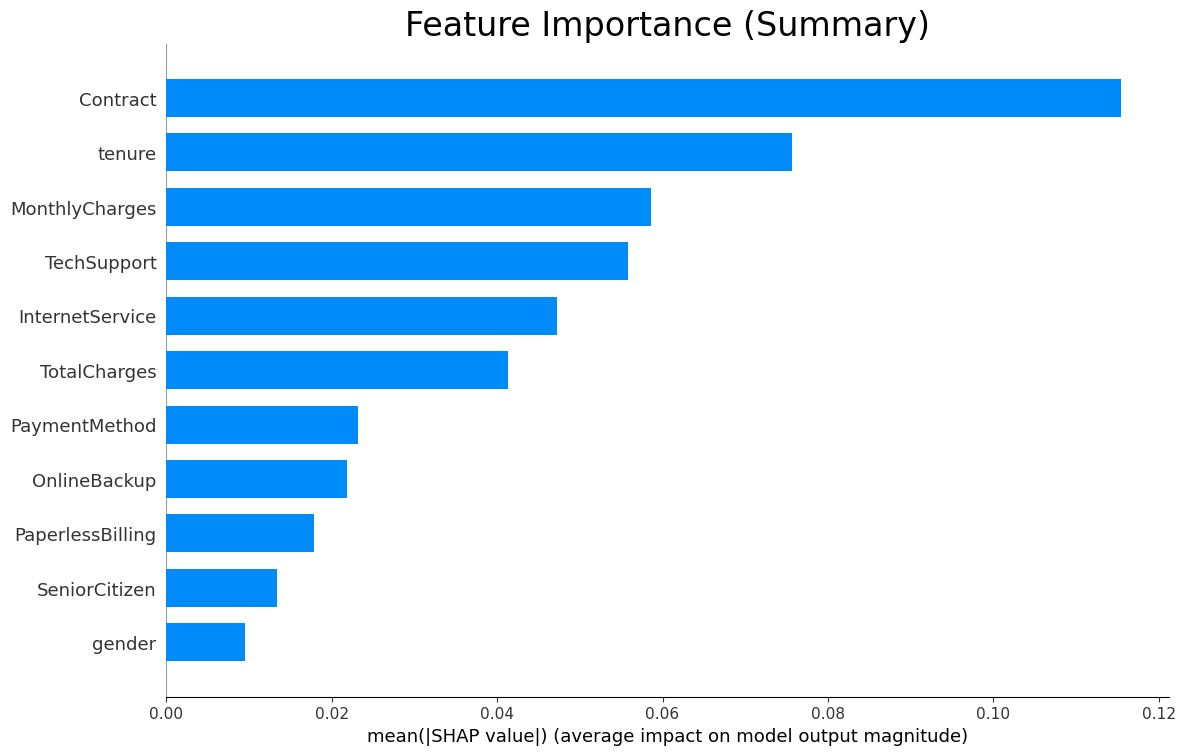

In [5]:
# Generate the summary plot
generate_summary_plot(shap_values, classifier, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


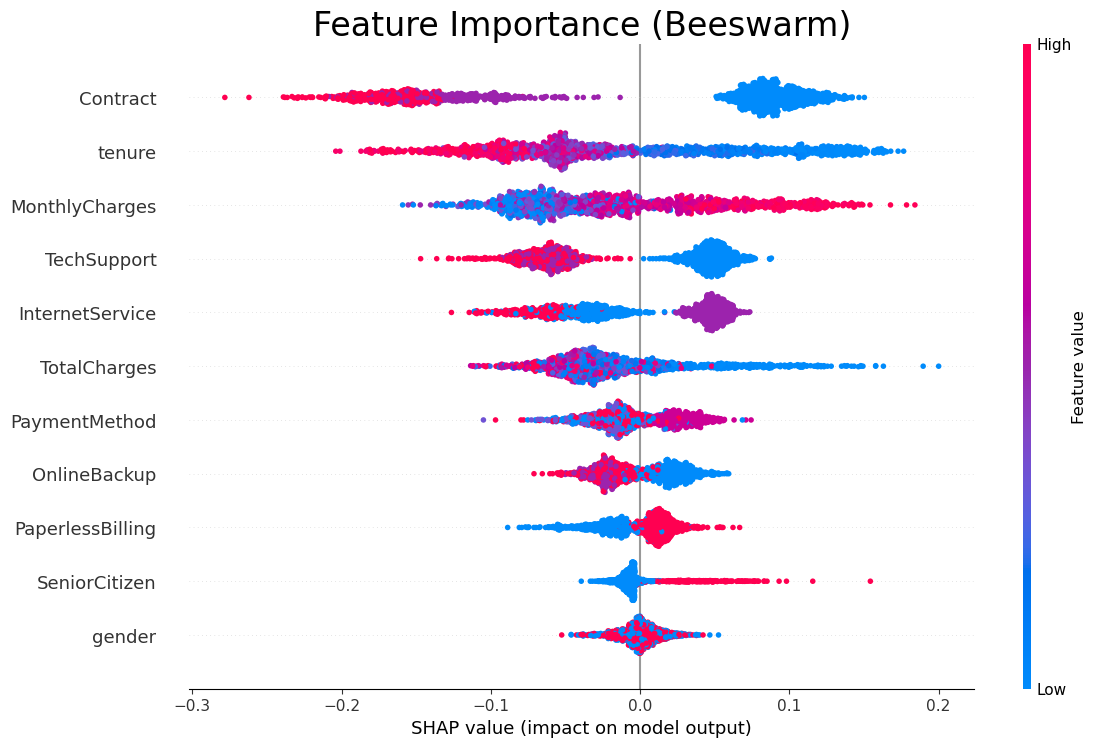

In [6]:
generate_beeswarm_plot(shap_values, classifier, X_test)

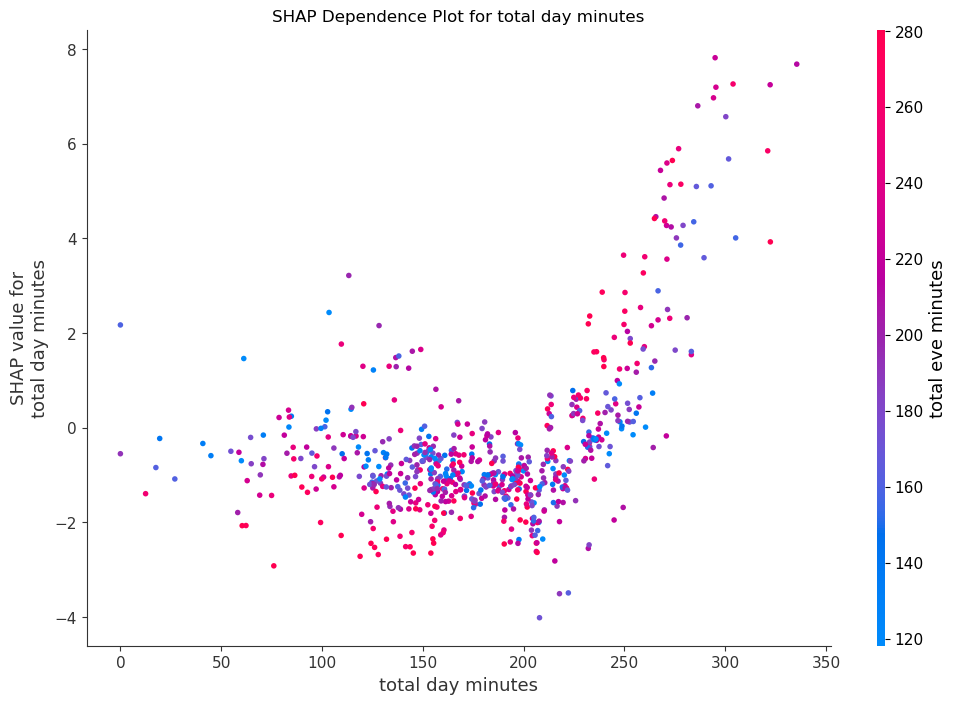

In [237]:
# Generate the dependence plot for a specific feature
generate_dependence_plot(shap_values, classifier, X_test, X_test.columns[2])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

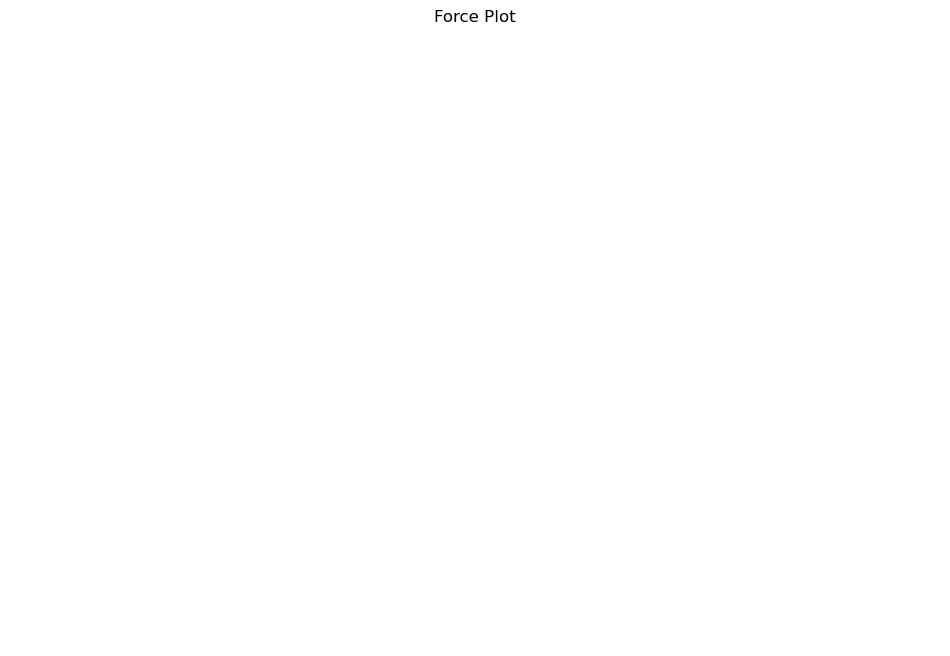

In [149]:
# Generate the force plot for a specific instance (replace 'index' with the index of the instance you're interested in)
index = 39
generate_force_plot(explainer, shap_values, X_test, classifier, index)

### Code End